<a href="https://colab.research.google.com/github/Dimitrispap123/movie-tag-prediction/blob/main/final3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Classification of Movie Plot Synopses Using Transformer Models

## Project Overview
This project applies transformer-based models to predict thematic tags from movie plot synopses. We compare multiple approaches and analyze when models succeed or fail.

## Dataset
- **Source**: MPST (Movie Plot Synopses with Tags) from Kaggle
- **Size**: 14,828 movie synopses → 14,518 after filtering
- **Tags**: 49 thematic tags (filtered from 71)
- **Task**: Multi-label classification

## Models Compared
1. **TF-IDF + Logistic Regression** - Traditional baseline
2. **BERT** - Transformer encoder with weighted loss
3. **RoBERTa** - Improved BERT pre-training


# Data Loading

In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# Download dataset
path = kagglehub.dataset_download("cryptexcode/mpst-movie-plot-synopses-with-tags")
print("Path to dataset files:", path)

# Check what files are in the folder
print("Files:", os.listdir(path))

# Load the dataset (adjust filename if needed after seeing the output above)
df = pd.read_csv(os.path.join(path, 'mpst_full_data.csv'))

# Display basic info
print(f"\nTotal samples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
df.head()

100%|██████████| 28.8M/28.8M [00:00<00:00, 91.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cryptexcode/mpst-movie-plot-synopses-with-tags/versions/1
Files: ['mpst_full_data.csv', 'partition.json']

Total samples: 14828
Columns: ['imdb_id', 'title', 'plot_synopsis', 'tags', 'split', 'synopsis_source']


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


# Exploratory Data Analysis

Total unique tags: 71


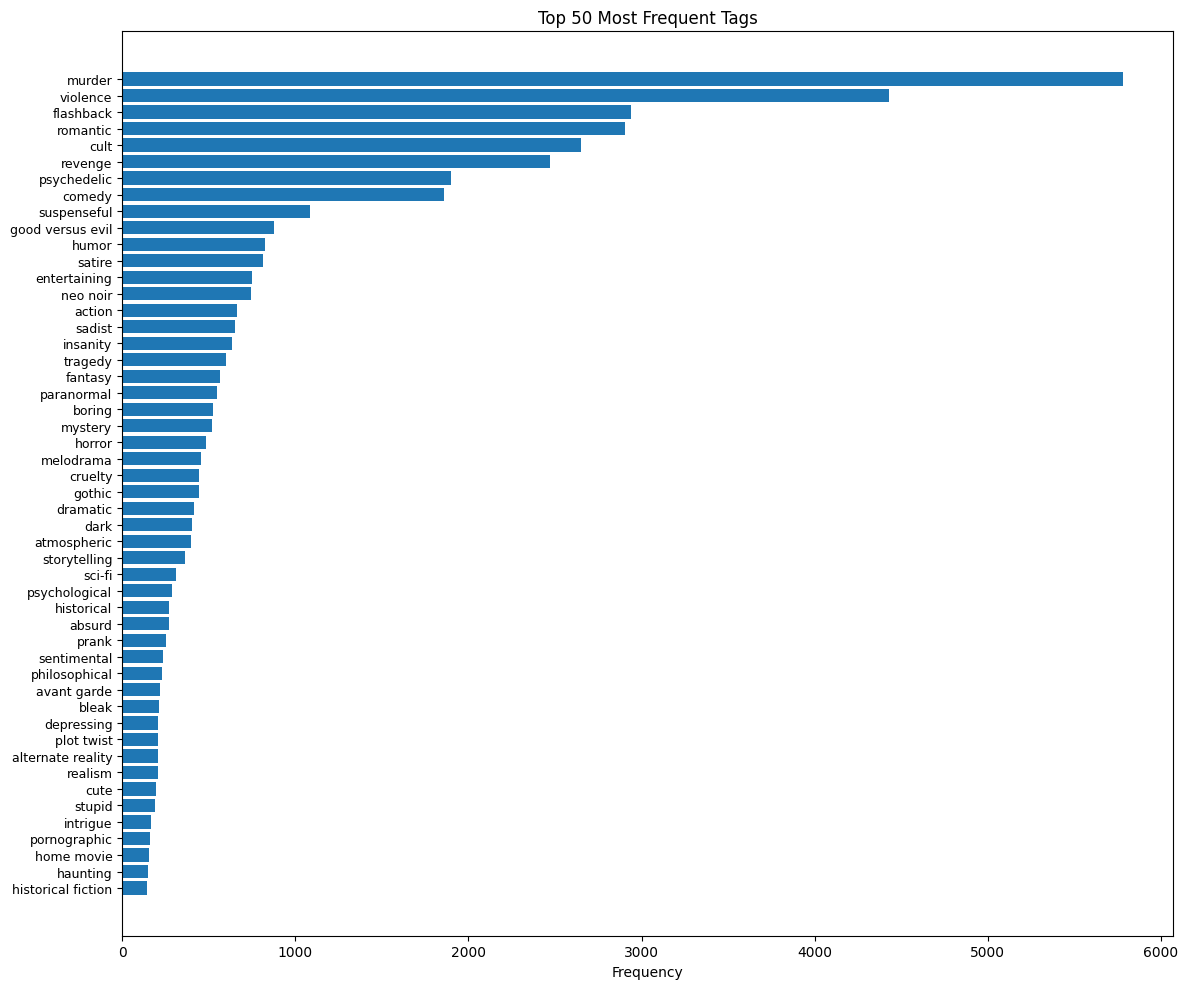


Tag count at different thresholds:
  >= 50 occurrences: 68 tags
  >= 100 occurrences: 58 tags
  >= 150 occurrences: 49 tags
  >= 200 occurrences: 43 tags
  >= 300 occurrences: 31 tags


In [2]:
# Count all tags
all_tags = []
for tags in df['tags'].dropna():
    all_tags.extend([t.strip() for t in tags.split(',')])

tag_counts = Counter(all_tags)
print(f"Total unique tags: {len(tag_counts)}")

# Plot top 50 tags
top_n = 50
top_tags = tag_counts.most_common(top_n)
tags, counts = zip(*top_tags)

plt.figure(figsize=(12, 10))
plt.barh(range(len(tags)), counts)
plt.yticks(range(len(tags)), tags, fontsize=9)
plt.xlabel('Frequency')
plt.title(f'Top {top_n} Most Frequent Tags')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Show frequency cutoff options
print("\nTag count at different thresholds:")
for threshold in [50, 100, 150, 200, 300]:
    count = len([t for t, c in tag_counts.items() if c >= threshold])
    print(f"  >= {threshold} occurrences: {count} tags")

# Data Preprocessing

In [3]:
# Set threshold
MIN_TAG_COUNT = 150

# Get selected tags
selected_tags = set([tag for tag, count in tag_counts.items() if count >= MIN_TAG_COUNT])
print(f"Selected {len(selected_tags)} tags")

# Filter tags for each sample
def filter_tags(tag_string):
    if pd.isna(tag_string):
        return None
    tags = [t.strip() for t in tag_string.split(',')]
    filtered = [t for t in tags if t in selected_tags]
    return ','.join(filtered) if filtered else None

df['filtered_tags'] = df['tags'].apply(filter_tags)

# Remove rows with no valid tags after filtering
df_filtered = df[df['filtered_tags'].notna()].copy()
print(f"Samples remaining: {len(df_filtered)} / {len(df)}")

# Check split distribution
print(f"\nSplit distribution:")
print(df_filtered['split'].value_counts())

# Save selected tags for later use
selected_tags_list = sorted(list(selected_tags))
print(f"\nSelected tags: {selected_tags_list}")

Selected 49 tags
Samples remaining: 14518 / 14828

Split distribution:
split
train    9278
test     2913
val      2327
Name: count, dtype: int64

Selected tags: ['absurd', 'action', 'alternate reality', 'atmospheric', 'avant garde', 'bleak', 'boring', 'comedy', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'flashback', 'good versus evil', 'gothic', 'haunting', 'historical', 'home movie', 'horror', 'humor', 'insanity', 'intrigue', 'melodrama', 'murder', 'mystery', 'neo noir', 'paranormal', 'philosophical', 'plot twist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suspenseful', 'tragedy', 'violence']


#Multi-hot encoding code

In [4]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Create multi-hot encoder
mlb = MultiLabelBinarizer(classes=selected_tags_list)

# Convert tags to lists and encode
def tags_to_list(tag_string):
    return [t.strip() for t in tag_string.split(',')]

df_filtered['tag_list'] = df_filtered['filtered_tags'].apply(tags_to_list)

# Create multi-hot encoded labels
y = mlb.fit_transform(df_filtered['tag_list'])
print(f"Label shape: {y.shape}")  # Should be (14518, 49)
print(f"Label classes: {mlb.classes_}")

# Split data using the existing split column
train_df = df_filtered[df_filtered['split'] == 'train']
val_df = df_filtered[df_filtered['split'] == 'val']
test_df = df_filtered[df_filtered['split'] == 'test']

train_idx = train_df.index
val_idx = val_df.index
test_idx = test_df.index

X_train = train_df['plot_synopsis'].values
X_val = val_df['plot_synopsis'].values
X_test = test_df['plot_synopsis'].values

y_train = y[df_filtered.index.get_indexer(train_idx)]
y_val = y[df_filtered.index.get_indexer(val_idx)]
y_test = y[df_filtered.index.get_indexer(test_idx)]

print(f"\nTrain: {len(X_train)} samples")
print(f"Val: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

# Check average tags per sample
print(f"\nAvg tags per movie: {y.sum(axis=1).mean():.2f}")
print(f"Tag distribution in training set: min={y_train.sum(axis=1).min()}, max={y_train.sum(axis=1).max()}")

Label shape: (14518, 49)
Label classes: ['absurd' 'action' 'alternate reality' 'atmospheric' 'avant garde' 'bleak'
 'boring' 'comedy' 'cruelty' 'cult' 'cute' 'dark' 'depressing' 'dramatic'
 'entertaining' 'fantasy' 'flashback' 'good versus evil' 'gothic'
 'haunting' 'historical' 'home movie' 'horror' 'humor' 'insanity'
 'intrigue' 'melodrama' 'murder' 'mystery' 'neo noir' 'paranormal'
 'philosophical' 'plot twist' 'pornographic' 'prank' 'psychedelic'
 'psychological' 'realism' 'revenge' 'romantic' 'sadist' 'satire' 'sci-fi'
 'sentimental' 'storytelling' 'stupid' 'suspenseful' 'tragedy' 'violence']

Train: 9278 samples
Val: 2327 samples
Test: 2913 samples

Avg tags per movie: 2.91
Tag distribution in training set: min=1, max=22


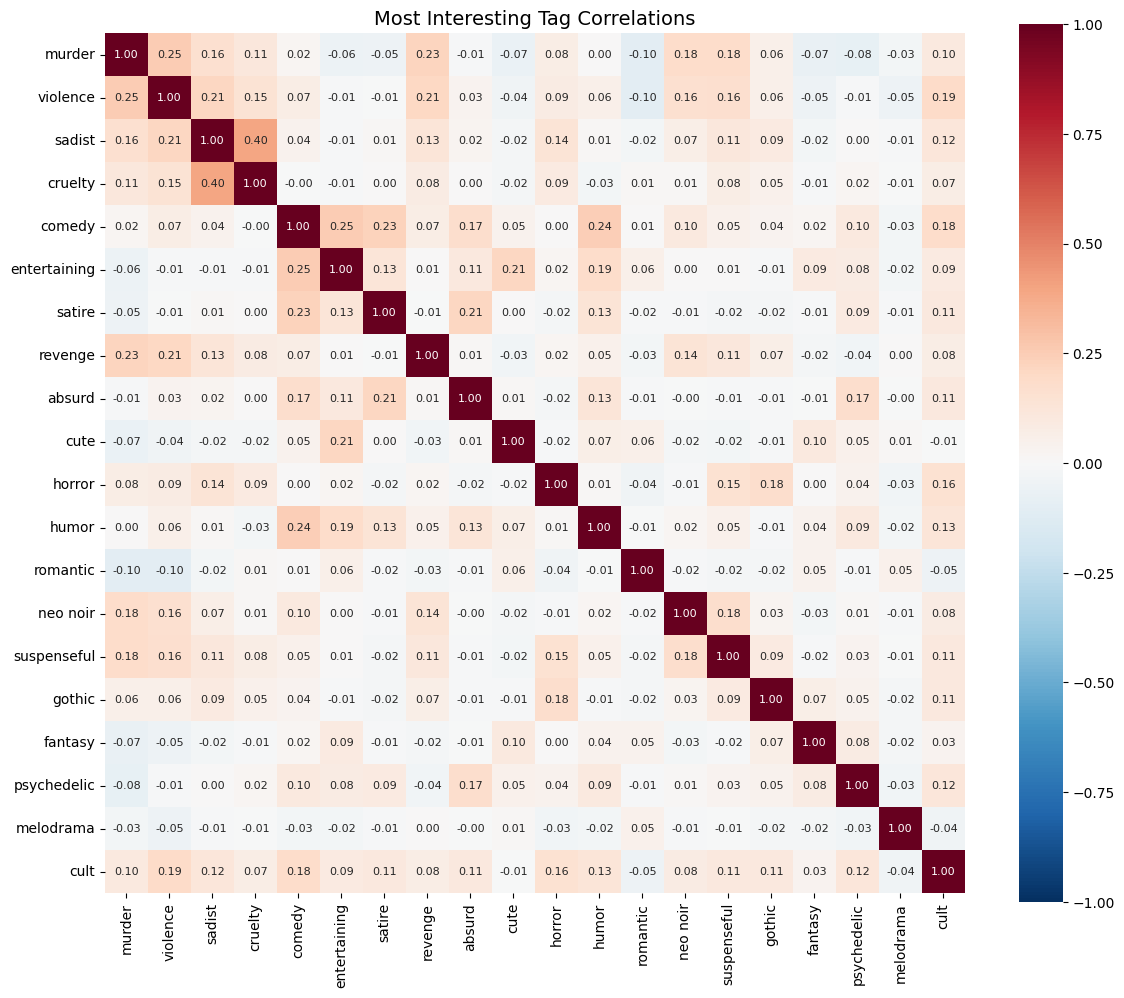

In [8]:
# Select tags with highest variance in correlations (most interesting)
correlation_variance = correlation_matrix.var().sort_values(ascending=False)
top_tags = correlation_variance.head(20).index.tolist()

# Subset correlation matrix
subset_corr = correlation_matrix.loc[top_tags, top_tags]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    subset_corr,
    annot=True,  # Show numbers
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    annot_kws={'size': 8}
)
plt.title('Most Interesting Tag Correlations', fontsize=14)
plt.tight_layout()
plt.show()

 ## Tokenization & Length Analysis




In [ ]:
!pip install transformers datasets -q

from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Check synopsis lengths to decide on max_length
synopsis_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in X_train[:500]]
print(f"Token lengths (sample of 500):")
print(f"  Mean: {np.mean(synopsis_lengths):.0f}")
print(f"  Median: {np.median(synopsis_lengths):.0f}")
print(f"  Max: {np.max(synopsis_lengths)}")
print(f"  95th percentile: {np.percentile(synopsis_lengths, 95):.0f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1663 > 512). Running this sequence through the model will result in indexing errors


Token lengths (sample of 500):
  Mean: 1586
  Median: 1216
  Max: 8062
  95th percentile: 4009


## Model Architecture

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

MAX_LENGTH = 512

class MovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Create datasets
train_dataset = MovieDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = MovieDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = MovieDataset(X_test, y_test, tokenizer, MAX_LENGTH)

# Create dataloaders
BATCH_SIZE = 16  # Reduce if you get OOM errors

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Quick test
batch = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  input_ids: {batch['input_ids'].shape}")
print(f"  attention_mask: {batch['attention_mask'].shape}")
print(f"  labels: {batch['labels'].shape}")

Train batches: 580
Val batches: 146
Test batches: 183

Batch shapes:
  input_ids: torch.Size([16, 512])
  attention_mask: torch.Size([16, 512])
  labels: torch.Size([16, 49])


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW

class BertMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels, dropout=0.1):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BertMultiLabelClassifier(num_labels=49)
model = model.to(device)

# Calculate class weights based on frequency (NEW)
tag_frequencies = y_train.sum(axis=0)
pos_weights = (len(y_train) - tag_frequencies) / tag_frequencies
pos_weights = torch.tensor(pos_weights, dtype=torch.float).to(device)

# Loss function with class weights (CHANGED)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# Optimizer and scheduler
EPOCHS = 5
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Class weights range: {pos_weights.min():.2f} - {pos_weights.max():.2f}")

Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Total training steps: 2900
Class weights range: 1.51 - 94.65


## BERT Training

In [ ]:
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    return total_loss / len(dataloader), all_preds, all_labels

# Training loop
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss, val_preds, val_labels = evaluate(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved best model!")


Epoch 1/5


Evaluating: 100%|██████████| 146/146 [01:44<00:00,  1.40it/s]


Train Loss: 1.2416
Val Loss: 1.1519
Saved best model!

Epoch 2/5


Evaluating: 100%|██████████| 146/146 [01:43<00:00,  1.41it/s]


Train Loss: 1.0906
Val Loss: 1.0861
Saved best model!

Epoch 3/5


Evaluating: 100%|██████████| 146/146 [01:43<00:00,  1.41it/s]


Train Loss: 0.9883
Val Loss: 1.0586
Saved best model!

Epoch 4/5


Evaluating: 100%|██████████| 146/146 [01:43<00:00,  1.41it/s]


Train Loss: 0.9036
Val Loss: 1.0613

Epoch 5/5


Evaluating: 100%|██████████| 146/146 [01:44<00:00,  1.40it/s]

Train Loss: 0.8469
Val Loss: 1.0696


## RoBERTa Training (Comparison Model)

In [ ]:
import gc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, classification_report

# Clear previous models from memory
gc.collect()
torch.cuda.empty_cache()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
print("RoBERTa tokenizer loaded!")


class MovieDatasetRoberta(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

class RobertaMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels, dropout=0.1):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

MAX_LENGTH = 512
BATCH_SIZE = 16

print("Creating datasets...")
train_dataset_roberta = MovieDatasetRoberta(X_train, y_train, roberta_tokenizer, MAX_LENGTH)
val_dataset_roberta = MovieDatasetRoberta(X_val, y_val, roberta_tokenizer, MAX_LENGTH)
test_dataset_roberta = MovieDatasetRoberta(X_test, y_test, roberta_tokenizer, MAX_LENGTH)

train_loader_roberta = DataLoader(train_dataset_roberta, batch_size=BATCH_SIZE, shuffle=True)
val_loader_roberta = DataLoader(val_dataset_roberta, batch_size=BATCH_SIZE)
test_loader_roberta = DataLoader(test_dataset_roberta, batch_size=BATCH_SIZE)

print(f"Train batches: {len(train_loader_roberta)}")
print(f"Val batches: {len(val_loader_roberta)}")
print(f"Test batches: {len(test_loader_roberta)}")


print("\nLoading RoBERTa model...")
roberta_model = RobertaMultiLabelClassifier(num_labels=49)
roberta_model = roberta_model.to(device)
print("Model loaded!")

# Weighted loss (same weights as BERT)
tag_frequencies = y_train.sum(axis=0)
pos_weights = (len(y_train) - tag_frequencies) / tag_frequencies
pos_weights = torch.tensor(pos_weights, dtype=torch.float).to(device)
criterion_roberta = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# Optimizer and scheduler
EPOCHS = 3
LEARNING_RATE = 2e-5

optimizer_roberta = AdamW(roberta_model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader_roberta) * EPOCHS
scheduler_roberta = get_linear_schedule_with_warmup(
    optimizer_roberta,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")


def train_epoch_roberta(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate_roberta(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    return total_loss / len(dataloader), all_preds, all_labels


print("\n" + "="*60)
print("TRAINING ROBERTA")
print("="*60)

best_val_loss_roberta = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    train_loss = train_epoch_roberta(
        roberta_model, train_loader_roberta, criterion_roberta,
        optimizer_roberta, scheduler_roberta, device
    )
    val_loss, val_preds_roberta, val_labels_roberta = evaluate_roberta(
        roberta_model, val_loader_roberta, criterion_roberta, device
    )

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss_roberta:
        best_val_loss_roberta = val_loss
        torch.save(roberta_model.state_dict(), 'best_roberta_model.pt')
        print("Saved best model!")


print("\n" + "="*60)
print("EVALUATING ROBERTA ON TEST SET")
print("="*60)

roberta_model.load_state_dict(torch.load('best_roberta_model.pt'))
test_loss_roberta, test_preds_roberta, test_labels_roberta = evaluate_roberta(
    roberta_model, test_loader_roberta, criterion_roberta, device
)

# Find optimal threshold
print("\nRoBERTa at different thresholds:")
for t in [0.5, 0.6, 0.7, 0.8]:
    preds = (test_preds_roberta >= t).astype(int)
    micro = f1_score(test_labels_roberta, preds, average='micro')
    macro = f1_score(test_labels_roberta, preds, average='macro')
    avg_preds = preds.sum(axis=1).mean()
    print(f"  t={t}: Micro F1={micro:.4f}, Macro F1={macro:.4f}, Avg preds={avg_preds:.2f}")


print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)

# Use best threshold for RoBERTa (adjust based on output above)
best_t_roberta = 0.6
y_pred_roberta_final = (test_preds_roberta >= best_t_roberta).astype(int)
micro_roberta = f1_score(test_labels_roberta, y_pred_roberta_final, average='micro')
macro_roberta = f1_score(test_labels_roberta, y_pred_roberta_final, average='macro')
avg_preds_roberta = y_pred_roberta_final.sum(axis=1).mean()

print(f"{'Model':<40} {'Micro F1':<12} {'Macro F1':<12} {'Avg Preds':<10}")
print("-"*70)
print(f"{'TF-IDF + Logistic Regression':<40} {0.2106:<12.4f} {0.0365:<12.4f} {0.53:<10.2f}")
print(f"{'BERT (512 tokens, weighted, t=0.6)':<40} {0.2586:<12.4f} {0.1974:<12.4f} {8.12:<10.2f}")
print(f"{'BERT (512 tokens, weighted, t=0.7)':<40} {0.2385:<12.4f} {0.1775:<12.4f} {3.18:<10.2f}")
print(f"{'RoBERTa (512 tokens, weighted, t=0.6)':<40} {micro_roberta:<12.4f} {macro_roberta:<12.4f} {avg_preds_roberta:<10.2f}")
print("-"*70)
print(f"{'Actual':<40} {'-':<12} {'-':<12} {2.97:<10.2f}")

# Per-tag performance for RoBERTa
print("\n" + "="*60)
print("PER-TAG PERFORMANCE (RoBERTa)")
print("="*60)
print(classification_report(test_labels_roberta, y_pred_roberta_final,
                            target_names=selected_tags_list, zero_division=0))

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

RoBERTa tokenizer loaded!
Creating datasets...
Train batches: 580
Val batches: 146
Test batches: 183

Loading RoBERTa model...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded!
Total training steps: 1740

TRAINING ROBERTA

Epoch 1/3


Evaluating: 100%|██████████| 146/146 [01:24<00:00,  1.73it/s]


Train Loss: 1.2190
Val Loss: 1.1139
Saved best model!

Epoch 2/3


Evaluating: 100%|██████████| 146/146 [01:28<00:00,  1.65it/s]


Train Loss: 1.0508
Val Loss: 1.0497
Saved best model!

Epoch 3/3


Evaluating: 100%|██████████| 146/146 [01:27<00:00,  1.67it/s]


Train Loss: 0.9524
Val Loss: 1.0262
Saved best model!

EVALUATING ROBERTA ON TEST SET


Evaluating: 100%|██████████| 183/183 [01:50<00:00,  1.66it/s]


RoBERTa at different thresholds:
  t=0.5: Micro F1=0.2554, Macro F1=0.1986, Avg preds=13.29
  t=0.6: Micro F1=0.2798, Macro F1=0.2170, Avg preds=8.41
  t=0.7: Micro F1=0.2785, Macro F1=0.2206, Avg preds=4.63
  t=0.8: Micro F1=0.2059, Macro F1=0.1881, Avg preds=1.91

FINAL MODEL COMPARISON
Model                                    Micro F1     Macro F1     Avg Preds 
----------------------------------------------------------------------
TF-IDF + Logistic Regression             0.2106       0.0365       0.53      
BERT (512 tokens, weighted, t=0.6)       0.2586       0.1974       8.12      
BERT (512 tokens, weighted, t=0.7)       0.2385       0.1775       3.18      
RoBERTa (512 tokens, weighted, t=0.6)    0.2798       0.2170       8.41      
----------------------------------------------------------------------
Actual                                   -            -            2.97      

PER-TAG PERFORMANCE (RoBERTa)
                   precision    recall  f1-score   support

        

## Baseline Model (TF-IDF + Logistic Regression)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

# TF-IDF baseline
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr_model = OneVsRestClassifier(LogisticRegression(max_iter=500))
lr_model.fit(X_train_tfidf, y_train)
y_test_pred_lr = lr_model.predict(X_test_tfidf)

print("--- TF-IDF + Logistic Regression Baseline ---")
print(f"Micro F1: {f1_score(y_test, y_test_pred_lr, average='micro'):.4f}")
print(f"Macro F1: {f1_score(y_test, y_test_pred_lr, average='macro'):.4f}")

--- TF-IDF + Logistic Regression Baseline ---
Micro F1: 0.2106
Macro F1: 0.0365


## Model Evaluation

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

# Convert probabilities to binary predictions (threshold = 0.5)
threshold = 0.5
y_test_pred_bert = (test_preds >= threshold).astype(int)

print("\n--- BERT ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Micro F1: {f1_score(test_labels, y_test_pred_bert, average='micro'):.4f}")
print(f"Macro F1: {f1_score(test_labels, y_test_pred_bert, average='macro'):.4f}")

# Comparison summary
print("\n--- Comparison ---")
print(f"{'Model':<30} {'Micro F1':<12} {'Macro F1':<12}")
print(f"{'-'*54}")
print(f"{'TF-IDF + LogReg':<30} {f1_score(y_test, y_test_pred_lr, average='micro'):<12.4f} {f1_score(y_test, y_test_pred_lr, average='macro'):<12.4f}")
print(f"{'BERT':<30} {f1_score(test_labels, y_test_pred_bert, average='micro'):<12.4f} {f1_score(test_labels, y_test_pred_bert, average='macro'):<12.4f}")

Evaluating: 100%|██████████| 183/183 [02:12<00:00,  1.39it/s]


--- BERT ---
Test Loss: 1.0604
Micro F1: 0.2340
Macro F1: 0.1862

--- Comparison ---
Model                          Micro F1     Macro F1    
------------------------------------------------------
TF-IDF + LogReg                0.2106       0.0365      
BERT                           0.2340       0.1862      


In [ ]:
print("Predictions per sample:")
print(f"  BERT - Mean: {y_test_pred_bert.sum(axis=1).mean():.2f}, Median: {np.median(y_test_pred_bert.sum(axis=1)):.0f}")
print(f"  TF-IDF - Mean: {y_test_pred_lr.sum(axis=1).mean():.2f}, Median: {np.median(y_test_pred_lr.sum(axis=1)):.0f}")
print(f"  Actual - Mean: {test_labels.sum(axis=1).mean():.2f}, Median: {np.median(test_labels.sum(axis=1)):.0f}")

print("Finding optimal threshold (higher range):")
for t in [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]:
    preds = (test_preds >= t).astype(int)
    micro = f1_score(test_labels, preds, average='micro')
    macro = f1_score(test_labels, preds, average='macro')
    avg_preds = preds.sum(axis=1).mean()
    print(f"  t={t}: Micro F1={micro:.4f}, Macro F1={macro:.4f}, Avg preds={avg_preds:.2f}")

# Per-tag F1 scores for BERT
from sklearn.metrics import classification_report
print("\nPer-tag performance (BERT):")
report = classification_report(test_labels, y_test_pred_bert, target_names=selected_tags_list, zero_division=0)
print(report)

Predictions per sample:
  BERT - Mean: 14.44, Median: 13
  TF-IDF - Mean: 0.53, Median: 0
  Actual - Mean: 2.97, Median: 2
Finding optimal threshold (higher range):
  t=0.5: Micro F1=0.2340, Macro F1=0.1862, Avg preds=14.44
  t=0.6: Micro F1=0.2625, Macro F1=0.2060, Avg preds=8.42
  t=0.7: Micro F1=0.2550, Macro F1=0.2001, Avg preds=3.92
  t=0.8: Micro F1=0.1612, Macro F1=0.1482, Avg preds=1.18
  t=0.85: Micro F1=0.0865, Macro F1=0.1030, Avg preds=0.44
  t=0.9: Micro F1=0.0238, Macro F1=0.0345, Avg preds=0.09
  t=0.95: Micro F1=0.0009, Macro F1=0.0022, Avg preds=0.00

Per-tag performance (BERT):
                   precision    recall  f1-score   support

           absurd       0.04      0.62      0.07        56
           action       0.11      0.81      0.19       129
alternate reality       0.04      0.77      0.08        35
      atmospheric       0.06      0.48      0.11        79
      avant garde       0.05      0.73      0.09        45
            bleak       0.03      0.65    

## Failure Analysis

TOP 10 EASIEST TAGS (highest F1)
             tag       f1  precision   recall  support
          murder 0.601618   0.668076 0.547186   1155.0
        violence 0.582627   0.562948 0.603732    911.0
        romantic 0.487382   0.453744 0.526405    587.0
     psychedelic 0.395644   0.308345 0.551899    395.0
            cult 0.352190   0.354128 0.350272    551.0
          comedy 0.346899   0.269578 0.486413    368.0
         revenge 0.331579   0.298578 0.372781    507.0
     suspenseful 0.322967   0.222039 0.592105    228.0
good versus evil 0.307888   0.203020 0.636842    190.0
        neo noir 0.299338   0.185246 0.779310    145.0

TOP 10 HARDEST TAGS (lowest F1)
              tag       f1  precision   recall  support
alternate reality 0.112360   0.060976 0.714286     35.0
      avant garde 0.102564   0.056738 0.533333     45.0
      sentimental 0.100977   0.055062 0.607843     51.0
     pornographic 0.093190   0.051793 0.464286     28.0
           stupid 0.092664   0.050104 0.615385   

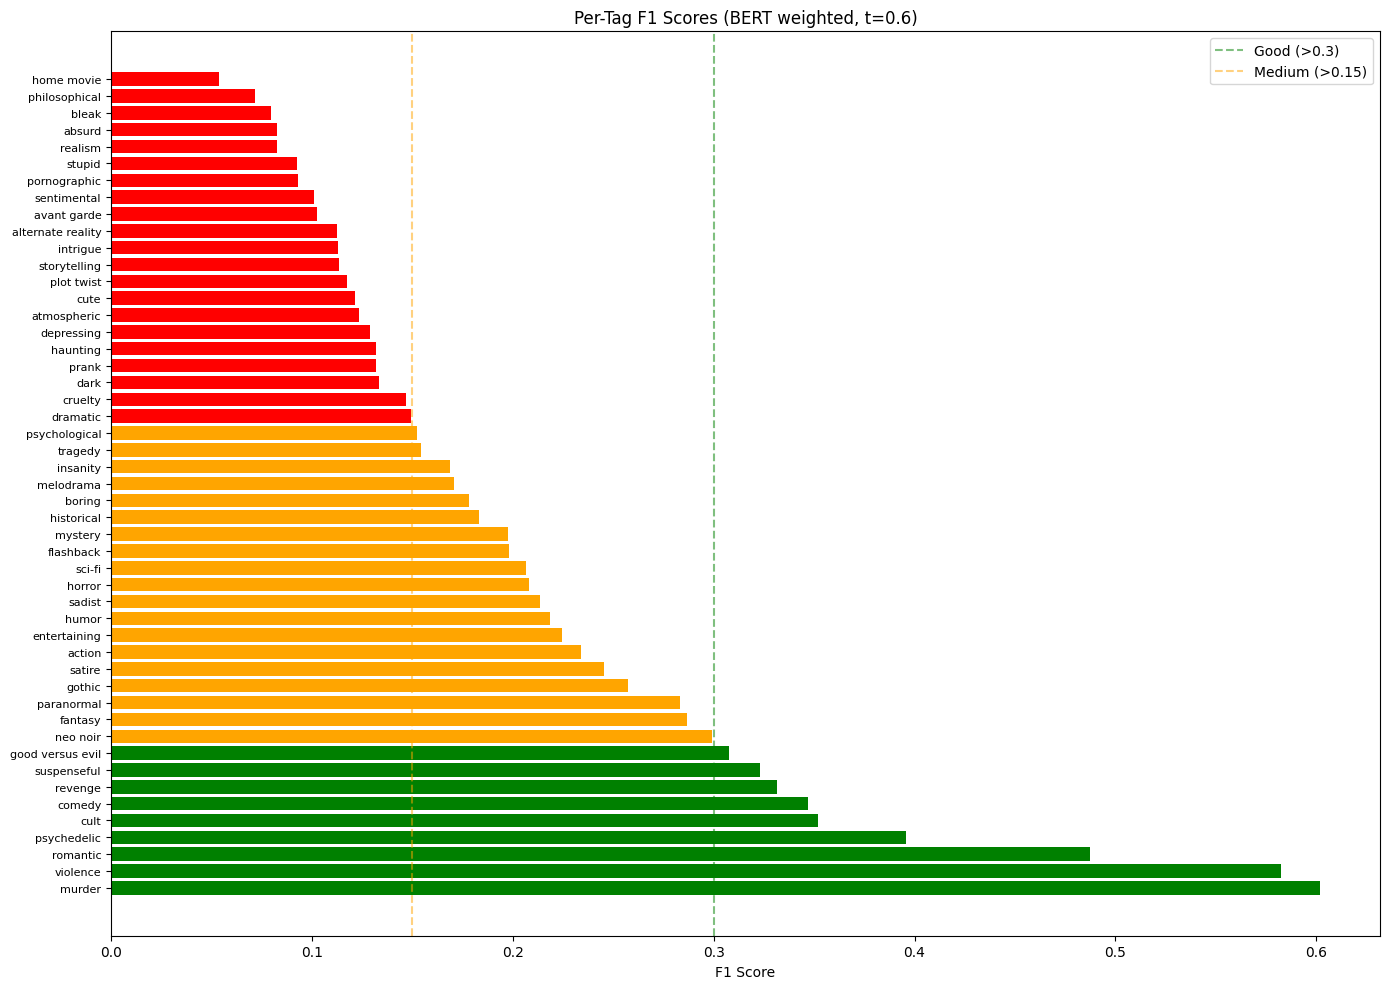

In [ ]:
# 1. Per-tag analysis: Easy vs Hard tags
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate per-tag metrics for BERT (weighted, t=0.6)
y_pred_final = (test_preds >= 0.6).astype(int)

tag_metrics = []
for i, tag in enumerate(selected_tags_list):
    f1 = f1_score(test_labels[:, i], y_pred_final[:, i], zero_division=0)
    prec = precision_score(test_labels[:, i], y_pred_final[:, i], zero_division=0)
    rec = recall_score(test_labels[:, i], y_pred_final[:, i], zero_division=0)
    support = test_labels[:, i].sum()
    tag_metrics.append({
        'tag': tag,
        'f1': f1,
        'precision': prec,
        'recall': rec,
        'support': support
    })

tag_df = pd.DataFrame(tag_metrics).sort_values('f1', ascending=False)

print("="*60)
print("TOP 10 EASIEST TAGS (highest F1)")
print("="*60)
print(tag_df.head(10).to_string(index=False))

print("\n" + "="*60)
print("TOP 10 HARDEST TAGS (lowest F1)")
print("="*60)
print(tag_df.tail(10).to_string(index=False))

# Visualize
plt.figure(figsize=(14, 10))
colors = ['green' if f1 > 0.3 else 'orange' if f1 > 0.15 else 'red' for f1 in tag_df['f1']]
plt.barh(range(len(tag_df)), tag_df['f1'].values, color=colors)
plt.yticks(range(len(tag_df)), tag_df['tag'].values, fontsize=8)
plt.xlabel('F1 Score')
plt.title('Per-Tag F1 Scores (BERT weighted, t=0.6)')
plt.axvline(x=0.3, color='green', linestyle='--', alpha=0.5, label='Good (>0.3)')
plt.axvline(x=0.15, color='orange', linestyle='--', alpha=0.5, label='Medium (>0.15)')
plt.legend()
plt.tight_layout()
plt.show()

SYNOPSIS LENGTH ANALYSIS

Truncated samples (>512 tokens): 2309 / 2913 (79.3%)

Average Jaccard Score:
  Non-truncated (≤512 tokens): 0.1710 (n=604)
  Truncated (>512 tokens):     0.1617 (n=2309)


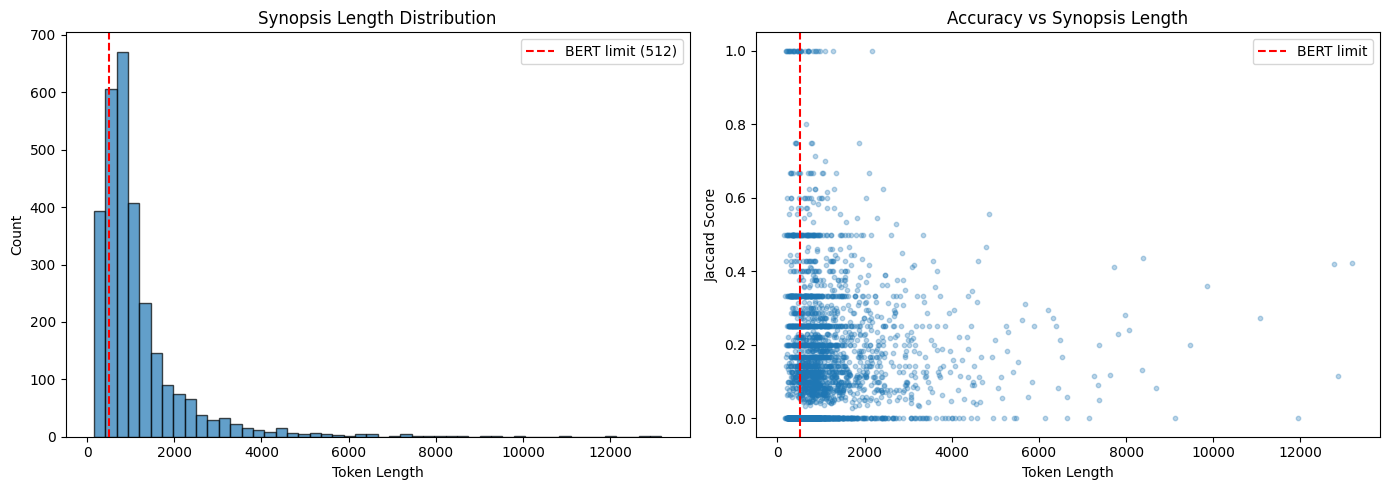

In [ ]:
# Get token lengths for test set
test_token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in X_test]

# Calculate per-sample accuracy (Jaccard similarity)
def jaccard_score_sample(y_true, y_pred):
    # Convert to boolean/int for bitwise operations
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    intersection = (y_true & y_pred).sum()
    union = (y_true | y_pred).sum()
    return intersection / union if union > 0 else 0

sample_scores = [jaccard_score_sample(test_labels[i], y_pred_final[i]) for i in range(len(test_labels))]

# Create dataframe for analysis
analysis_df = pd.DataFrame({
    'token_length': test_token_lengths,
    'jaccard_score': sample_scores,
    'actual_tags': test_labels.sum(axis=1),
    'predicted_tags': y_pred_final.sum(axis=1),
    'truncated': [l > 512 for l in test_token_lengths]
})

print("="*60)
print("SYNOPSIS LENGTH ANALYSIS")
print("="*60)
print(f"\nTruncated samples (>512 tokens): {analysis_df['truncated'].sum()} / {len(analysis_df)} ({100*analysis_df['truncated'].mean():.1f}%)")

# Compare accuracy for truncated vs non-truncated
truncated_scores = analysis_df[analysis_df['truncated']]['jaccard_score']
non_truncated_scores = analysis_df[~analysis_df['truncated']]['jaccard_score']

print(f"\nAverage Jaccard Score:")
print(f"  Non-truncated (≤512 tokens): {non_truncated_scores.mean():.4f} (n={len(non_truncated_scores)})")
print(f"  Truncated (>512 tokens):     {truncated_scores.mean():.4f} (n={len(truncated_scores)})")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Length distribution
axes[0].hist(test_token_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=512, color='red', linestyle='--', label='BERT limit (512)')
axes[0].set_xlabel('Token Length')
axes[0].set_ylabel('Count')
axes[0].set_title('Synopsis Length Distribution')
axes[0].legend()

# Accuracy vs length
axes[1].scatter(analysis_df['token_length'], analysis_df['jaccard_score'], alpha=0.3, s=10)
axes[1].axvline(x=512, color='red', linestyle='--', label='BERT limit')
axes[1].set_xlabel('Token Length')
axes[1].set_ylabel('Jaccard Score')
axes[1].set_title('Accuracy vs Synopsis Length')
axes[1].legend()

plt.tight_layout()
plt.show()